---
title: Multi-output Gaussian Process (Sensor Network)
format: 
  html:
    code-fold: false
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aavelozb/aavelozb.github.io/blob/main/gp/gp03-sensors-network.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import mogptk
import torch


plot_params = {'legend.fontsize': 18,
               'figure.figsize': (15, 7),
               'xtick.labelsize':'18',
               'ytick.labelsize':'18',
               'axes.titlesize':'24',
               'axes.labelsize':'22'}
plt.rcParams.update(plot_params)


rng = np.random.default_rng(123)

T = 500
n_nodes = 5

t = np.linspace(0, 10, T)
t1_lost = np.linspace(4, 5, 100)
X = np.zeros((T,n_nodes))

X[:,0] = np.sin(t * (2 * np.pi)) + np.sin(t * (3 * np.pi))
X[:,1] = np.sin((t-1) * (2 * np.pi)) + np.sin((t-1) * (3 * np.pi))
X[:,2] = np.sin(t * (2 * np.pi)) + np.sin(t * (4 * np.pi))
X[:,3] = np.sin((t-1) * (2 * np.pi)) + 0.5*np.sin((t-1) * (4 * np.pi))
X[:,4] = 0.3*np.sin((t-1) * (2 * np.pi)) + 0.8*np.sin((t-1) * (8 * np.pi))

In [2]:
torch.manual_seed(1);

T = 500
n_nodes = 5
t = np.linspace(0, 10, T)
X = np.zeros((T, n_nodes))
X[:, 0] = np.sin(t * (2 * np.pi)) + np.sin(t * (3 * np.pi))
X[:, 1] = np.sin((t-1) * (2 * np.pi)) + np.sin((t-1) * (3 * np.pi))
X[:, 2] = np.sin(t * (2 * np.pi)) + np.sin(t * (4 * np.pi))
X[:, 3] = np.sin((t-1) * (2 * np.pi)) + 0.5*np.sin((t-1) * (4 * np.pi))
X[:, 4] = 0.3*np.sin((t-1) * (2 * np.pi)) + 0.8*np.sin((t-1) * (8 * np.pi))
columns = [f"Node{i+1}" for i in range(n_nodes)]
df_synth = pd.DataFrame(X, columns=columns)
df_synth['Time'] = t
df_synth = df_synth[['Time'] + columns]
dataset = mogptk.LoadDataFrame(df_synth, x_col='Time', y_col=columns)

for channel in dataset:
    channel.remove_randomly(pct=0.4)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, 1.0)
dataset[2].remove_relative_range(0.9, 1.0)
dataset[3].remove_relative_range(0.8, 1.0)
dataset[4].remove_relative_range(0.0, 0.2)

channels = []
for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformStandard())
    channels.append(channel)

# dataset.plot(transformed=True, figsize=(10,10));
n_train = channels[0].get_train_data()[0].shape[0]
n_test = channels[0].get_test_data()[0].shape[0]
n_train+n_test

500

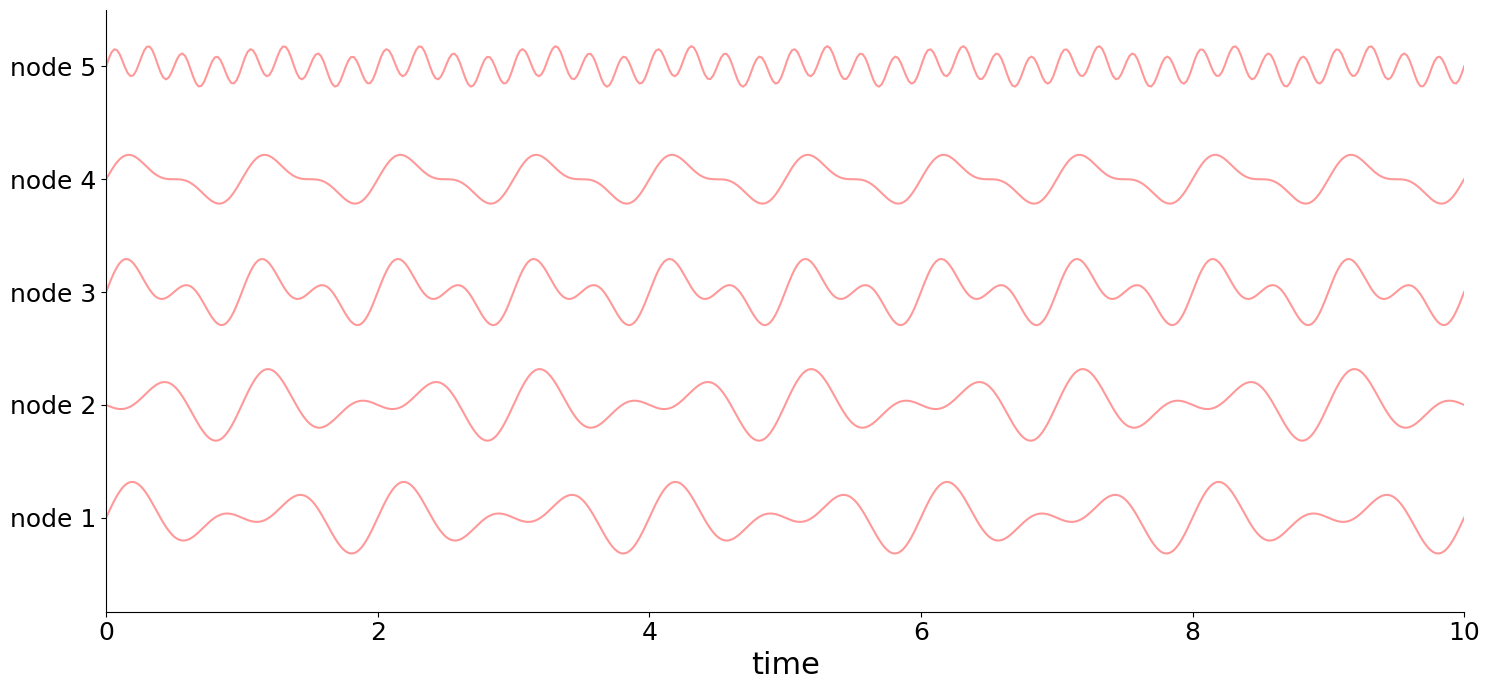

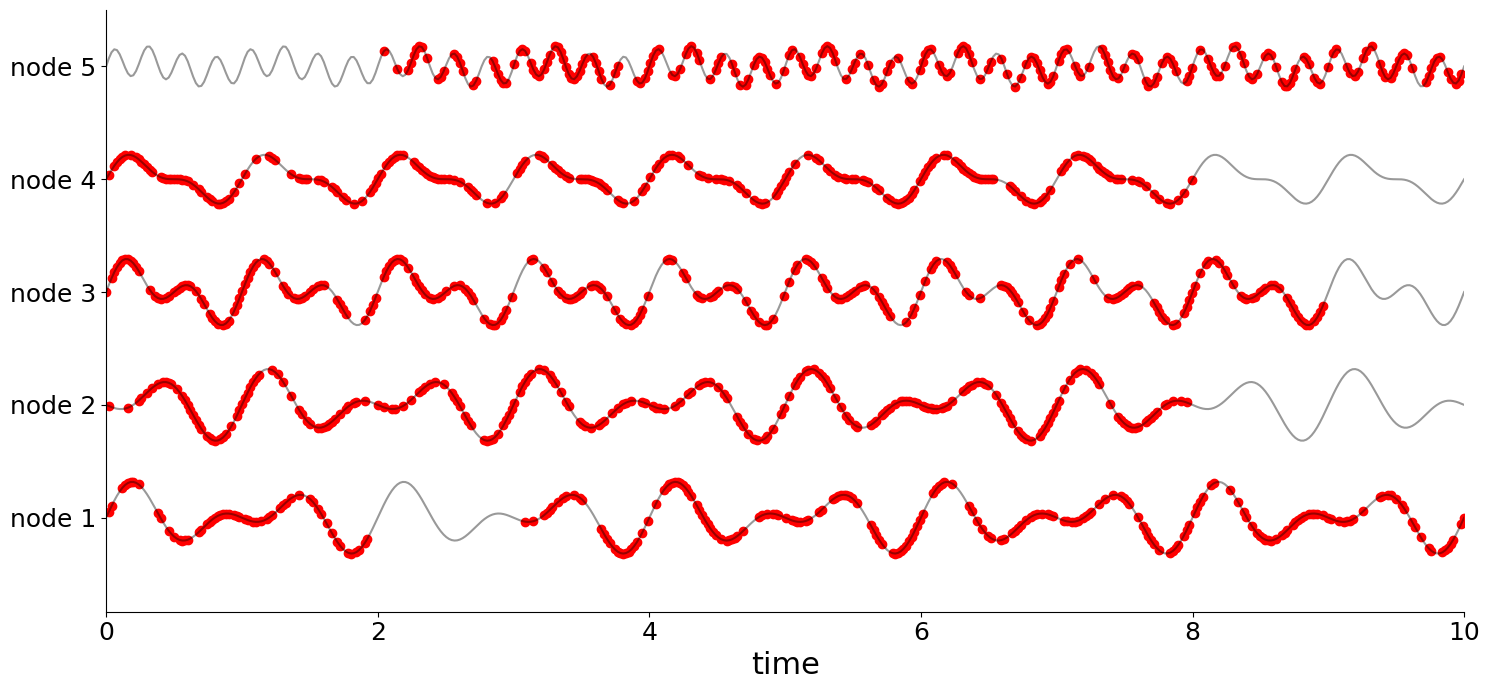

In [3]:
offset = 6.0
y_offsets = np.arange(n_nodes) * offset

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
for i in range(n_nodes):
    plt.plot(t, X[:,i] + y_offsets[i], alpha=0.4, color='r')

ax.set_yticks(y_offsets, [f"node {i+1}" for i in range(n_nodes)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.set_xlim([0, 10])
ax.set_ylim([-5, 27])
plt.xlabel("time")
plt.tight_layout()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
for i in range(n_nodes):
    plt.plot(t, X[:,i] + y_offsets[i], alpha=0.4, color='k')
    t_train, x_train = channels[i].get_train_data()
    plt.scatter(t_train, x_train + y_offsets[i], color='red')

ax.set_yticks(y_offsets, [f"node {i+1}" for i in range(n_nodes)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.set_xlim([0, 10])
ax.set_ylim([-5, 27])
plt.xlabel("time")
plt.tight_layout()

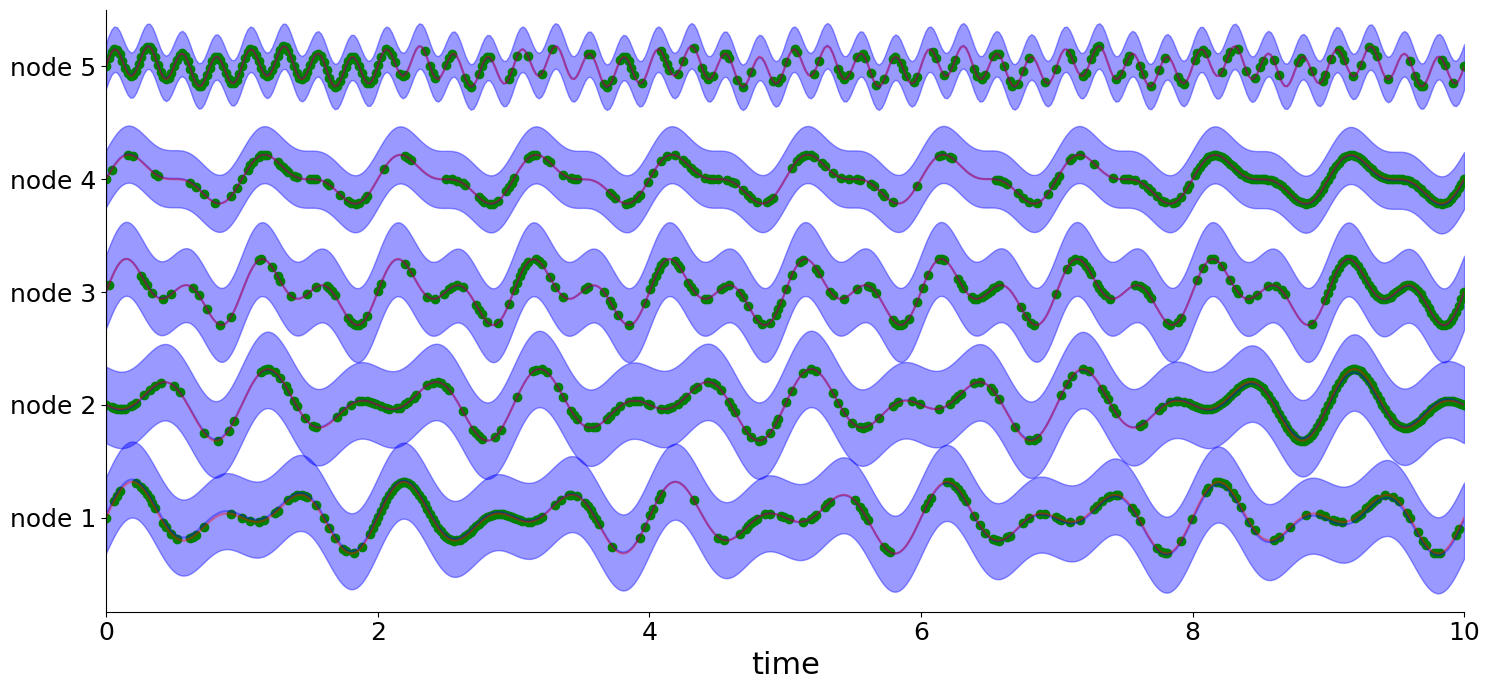

In [4]:
model = mogptk.MOSM(dataset, Q=3)
model.init_parameters(method='BNSE')

Xt, Mu, Lower, Upper = model.predict()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
for i in range(n_nodes):
    plt.plot(Xt[i], Mu[i] + y_offsets[i], alpha=0.4, color='b')
    plt.fill_between( np.squeeze(Xt[i]), Lower[i] + y_offsets[i], Upper[i] + y_offsets[i], alpha=0.4, color='b' )
    plt.plot(t, X[:,i] + y_offsets[i], alpha=0.4, color='r')
    t_test, x_test = channels[i].get_test_data()
    plt.scatter(t_test, x_test + y_offsets[i], color='green')

ax.set_yticks(y_offsets, [f"node {i+1}" for i in range(n_nodes)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.set_xlim([0, 10])
ax.set_ylim([-5, 27])
plt.xlabel("time")
plt.tight_layout()


In [5]:
model.train(method='Adam', lr=0.01, iters=1000, verbose=True);

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 5
‣ Parameters: 80
‣ Training points: 1258
‣ Iterations: 1000


/Users/aveloz/miniconda3/lib/python3.9/site-packages/mogptk/model.py:384: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(self.gpr.loss())


     0/1000   0:00:00  loss=     1248.23 (warmup)
    48/1000   0:00:10  loss=     1184.74
   101/1000   0:00:20  loss=     1116.73
   153/1000   0:00:30  loss=     1054.27
   206/1000   0:00:40  loss=     988.854
   258/1000   0:00:50  loss=     932.167
   310/1000   0:01:00  loss=     862.731
   360/1000   0:01:10  loss=     801.434
   413/1000   0:01:20  loss=     738.048
   465/1000   0:01:30  loss=     673.084
   517/1000   0:01:40  loss=     615.362
   566/1000   0:01:50  loss=     551.007
   616/1000   0:02:00  loss=     487.771
   667/1000   0:02:10  loss=     426.397
   717/1000   0:02:20  loss=     363.946
   764/1000   0:02:30  loss=     307.042
   812/1000   0:02:40  loss=     271.866
   863/1000   0:02:50  loss=     195.433
   914/1000   0:03:00  loss=     142.252
   965/1000   0:03:10  loss=     103.193
  1000/1000   0:03:16  loss=     46.8325
Optimization finished in 3 minutes 16 seconds


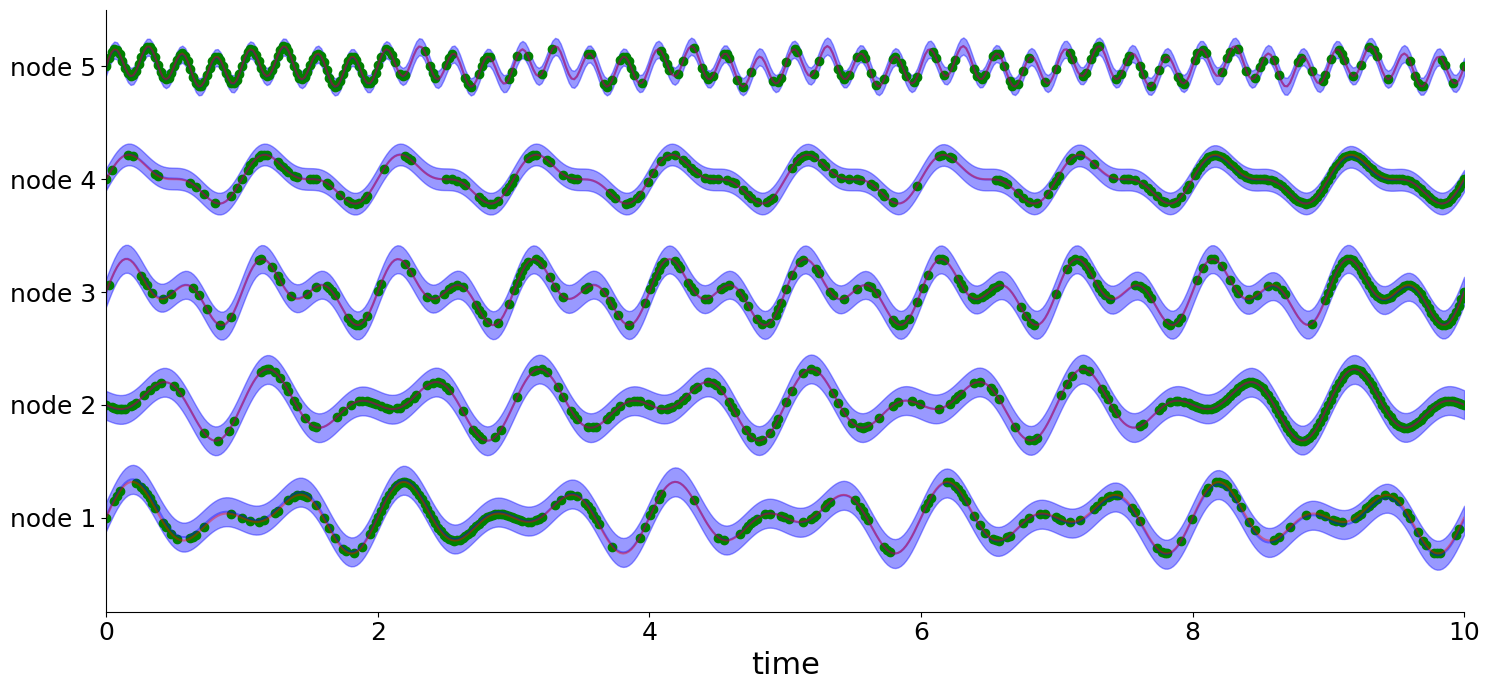

In [6]:
Xt, Mu, Lower, Upper = model.predict()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
for i in range(n_nodes):
    plt.plot(Xt[i], Mu[i] + y_offsets[i], alpha=0.4, color='b')
    plt.fill_between( np.squeeze(Xt[i]), Lower[i] + y_offsets[i], Upper[i] + y_offsets[i], alpha=0.4, color='b' )
    plt.plot(t, X[:,i] + y_offsets[i], alpha=0.4, color='r')
    t_test, x_test = channels[i].get_test_data()
    plt.scatter(t_test, x_test + y_offsets[i], color='green')

ax.set_yticks(y_offsets, [f"node {i+1}" for i in range(n_nodes)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.set_xlim([0, 10])
ax.set_ylim([-5, 27])
plt.xlabel("time")
plt.tight_layout()